<a href="https://colab.research.google.com/github/OrgadShlishman/TAU-DLinMedicalImaging/blob/main/Segformer_Dino_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run RAVIR dataset on DINOv2 + SegFormer for Semantic Segmentation

## Packages and Libraries Installations and Imports

In [1]:
!pip install --upgrade transformers

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import math
import time
import cv2
import os

import matplotlib.pyplot as plt
import albumentations as aug
import torch.nn as nn
import numpy as np

from transformers import AutoImageProcessor, SegformerModel, SegformerForSemanticSegmentation, SegformerDecodeHead, SegformerImageProcessor
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from tqdm.notebook import tqdm
from transformers import AdamW


## Define the path to your dataset

In [3]:
root_dir = '/content/drive/MyDrive/Deep Learning/Project/DataSet/RAVIR Dataset/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Model Functions Definitions

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
        self.SegformerEncoder = SegformerModel.from_pretrained("nvidia/MiT-b5")
        self.dino_embed_dim = self.dinov2.embed_dim
        self.dino_patch_size = self.dinov2.patch_size
        self.resize = transforms.Resize((448,448))

    def forward(self,x):
      batch_size = x.shape[0]
      with torch.no_grad(): # freeze Dino backbone
        x1 = self.resize(x) # dino input must be a multiple of 14, we choose 448
        final_dim = (x1.shape[2] / self.dino_patch_size, x1.shape[3] / self.dino_patch_size)
        x1 = self.dinov2.forward_features(x1)
        x1 = x1['x_norm_patchtokens'].reshape((batch_size,self.dino_embed_dim,int(final_dim[0]),int(final_dim[1]))) #  calculate dino feature map
      x2 = self.SegformerEncoder(x,output_hidden_states=True)
      y = list(x2.hidden_states) # all segformer hidden states
      y.append(x1) # add dino feature map
      total_encoded = tuple(y)

      return total_encoded

class SegformerMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.proj = nn.Linear(in_features, out_features)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = hidden_states.flatten(2).transpose(1, 2)
        hidden_states = self.proj(hidden_states)
        return hidden_states

class SegformerDecodeHead(nn.Module):
    def __init__(self, out_channels = 3, num_encoder_blocks = 5, mlp_features=768):
        super(SegformerDecodeHead, self).__init__()
        mlps = []
        for i, in_features in zip(range(num_encoder_blocks),[64, 128, 320, 512,1536]): # feature dimention of each encoder block, last one is dino (1536 for GIANT model and 1024 for LARGE model)
            mlp = SegformerMLP(in_features, mlp_features)
            mlps.append(mlp)
        self.linear_c = nn.ModuleList(mlps)

        # the following 3 layers implement the ConvModule of the original implementation
        self.linear_fuse = nn.Conv2d(
            in_channels=mlp_features * num_encoder_blocks,
            out_channels=mlp_features,
            kernel_size=1,
            bias=False,
        )
        self.batch_norm = nn.BatchNorm2d(mlp_features)
        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(p=0.1, inplace=False)
        self.classifier = nn.Conv2d(mlp_features, out_channels, kernel_size=1)


    def forward(self, encoder_hidden_states: torch.FloatTensor) -> torch.Tensor:
        batch_size = encoder_hidden_states[-1].shape[0]

        all_hidden_states = ()
        for encoder_hidden_state, mlp in zip(encoder_hidden_states, self.linear_c):
            # unify channel dimension
            height, width = encoder_hidden_state.shape[2], encoder_hidden_state.shape[3]
            encoder_hidden_state = mlp(encoder_hidden_state)
            encoder_hidden_state = encoder_hidden_state.permute(0, 2, 1)
            encoder_hidden_state = encoder_hidden_state.reshape(batch_size, -1, height, width)
            # upsample
            encoder_hidden_state = nn.functional.interpolate(
                encoder_hidden_state, size=encoder_hidden_states[0].size()[2:], mode="bilinear", align_corners=False
            )
            all_hidden_states += (encoder_hidden_state,)

        hidden_states = self.linear_fuse(torch.cat(all_hidden_states[::-1], dim=1))
        hidden_states = self.batch_norm(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # logits are of shape (batch_size, num_labels, height/4, width/4)
        logits = self.classifier(hidden_states)

        return logits

class SegformerDinoV2(nn.Module):
    def __init__(self, out_channels = 3, num_encoder_blocks = 5, mlp_features=768):
        super(SegformerDinoV2, self).__init__()
        self.Encoder = Encoder()
        self.Decoder = SegformerDecodeHead(out_channels=out_channels, num_encoder_blocks = num_encoder_blocks, mlp_features = mlp_features)

    def forward(self,x):
      x = self.Encoder(x)
      output = self.Decoder(x)

      return output

In [5]:
def dice_coef_loss(predictions, ground_truths, num_classes=2, dims=(1, 2), smooth=1e-8):
    """Smooth Dice coefficient + Cross-entropy loss function."""

    ground_truth_oh = nn.functional.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = nn.functional.softmax(predictions, dim=1).permute(0, 2, 3, 1)

    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)

    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()

    CE = nn.functional.cross_entropy(predictions, ground_truths)

    return (1.0 - dice_mean) + CE

In [6]:
def train_model(model, train_dataset, num_epochs, batch_size, learning_rate, device):
    model.to(device)
    model.train()  # Set the model to training mode

    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Create DataLoader to load the data in batches with num_workers
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    pbar = tqdm(train_loader)
    for epoch in range(num_epochs):
        if epoch % 51 == 0:
            learning_rate = learning_rate / 2
            for g in optimizer.param_groups:
                g['lr'] = learning_rate

        total_loss = 0.0
        for idx, batch in enumerate(pbar):
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(inputs)
            upsampled_logits = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)

            # Compute the loss
            loss = dice_coef_loss(upsampled_logits, labels, num_classes=3)

            # Zero the gradients, backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate and print average loss for the epoch
        average_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    print("Training completed.")


## Create a model and prepare the dataset for Semantic Segmentation

In [7]:
Model = SegformerDinoV2(out_channels=3, num_encoder_blocks = 5, mlp_features=768)
Model.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [00:42<00:00, 106MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist 

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

SegformerDinoV2(
  (Encoder): Encoder(
    (dinov2): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-39): 40 x NestedTensorBlock(
          (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1536, out_features=4608, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1536, out_features=1536, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
          (mlp): SwiGLUFFNFused(
            (w12): Linear(in_features=1536, out_features=8192, bias=True)
            (w3): Linear(in_features=4096, out_features=1536, bias=True)
          )
      

In [8]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path,"images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "mask")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        # read annotations
        annotation_file_names = []

        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps. \nNum of image = "+str(len(self.images))+"\nNum of masks = "+str(len(self.annotations))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        segmentation_map[segmentation_map==128]=1 # the loss in the segformer network only works of the labels are 0,1,2,3,... etc so i changed it
        segmentation_map[segmentation_map==255]=2

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")


        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [9]:
transform = aug.Compose([
    aug.Flip(p=0.5),
    aug.RandomCrop(width=256, height=256),
    aug.RandomBrightnessContrast(p=0.2),
    aug.SafeRotate(p=0.5)
])

feature_extractor = SegformerImageProcessor(do_resize=False,align=False, reduce_zero_label=False,do_normalize = False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)

<ipython-input-9-691c62429ab3>:2: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  aug.Flip(p=0.5),
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'align', 'reduce_zero_label'
  return func(*args, **kwargs)


## Train the model

##### Define training functions
*Use enhanced_train_model for faster (But less effective in terms of accuracy) results.


*Use train_model for more accurate result and longer training time.

In [10]:
def enhanced_train_model(model, train_dataset, num_epochs, batch_size, learning_rate, device):
    model.to(device)
    model.train()  # Set the model to training mode

    # Define optimizer using PyTorch's AdamW
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Create DataLoader with num_workers and pin_memory
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Initialize GradScaler for mixed precision training
    scaler = GradScaler()

    # Initialize learning rate scheduler
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    pbar = tqdm(train_loader)

    for epoch in range(num_epochs):
        total_loss = 0.0
        for idx, batch in enumerate(pbar):
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            # Mixed precision context
            with autocast():
                outputs = model(inputs)
                upsampled_logits = torch.nn.functional.interpolate(
                    outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )
                loss = dice_coef_loss(upsampled_logits, labels, num_classes=3)

            # Backward pass with mixed precision scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        # Adjust learning rate
        scheduler.step()

        # Calculate and print average loss for the epoch
        average_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    print("Training completed.")

In [11]:
def train_model(model, train_dataset, num_epochs, batch_size, learning_rate, device):
    model.to(device)
    model.train()  # Set the model to training mode

    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss()
    learning_rate = learning_rate
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Create DataLoader to load the data in batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    pbar = tqdm(train_loader)
    for epoch in range(num_epochs):
        if epoch % 51 == 0:
          learning_rate = learning_rate / 2
          for g in optimizer.param_groups:
            g['lr'] = learning_rate
        total_loss = 0.0
        for idx, batch in enumerate(pbar):
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(inputs)
            upsampled_logits = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits # upsampled_logits.argmax(dim=1)


            # Compute the loss
            #loss = criterion(predicted, labels)
            loss = dice_coef_loss(upsampled_logits, labels, num_classes=3)

            # Zero the gradients, backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate and print average loss for the epoch
        average_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    print("Training completed.")

##### Train the model
Usage example:


In [12]:
train_model(model = Model, train_dataset = train_dataset, num_epochs =2, batch_size = 4, learning_rate = 0.001, device = device)
# enhanced_train_model(model = Model, train_dataset = train_dataset, num_epochs = 100, batch_size = 4, learning_rate = 0.001, device = device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/2], Loss: 1.4043
Epoch [2/2], Loss: 0.8712
Training completed.


##### Loading a model (instead of training it) - set load_model = 'True'

See also: Usage example

In [13]:
load_model = False

if load_model:
  Model.load_state_dict(torch.load(os.path.join(root_dir,'400_epochs_FastDup_for_test_and_train_images_both_new_and_original_SegformerDinoV2GIANT_state_dict.pt')))

## More applications

##### display training results (On validation set)

tensor(1.)
tensor(0.)
torch.Size([4, 3, 256, 256])
tensor(0.9882)
tensor(0.0824)
torch.Size([4, 3, 256, 256])


<Figure size 640x480 with 0 Axes>

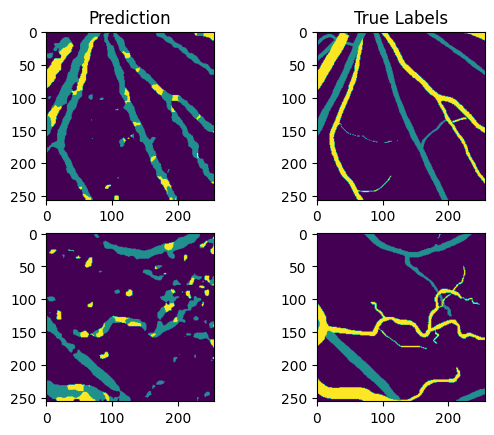

In [14]:
transform_val = aug.Compose([
    aug.RandomCrop(width=256, height=256),
])

valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform_val, train=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)


Model.eval()
with torch.no_grad():
  for idx, batch in enumerate(valid_dataloader):
      pixel_values = batch["pixel_values"].to(device)
      print(torch.max(batch["pixel_values"]))
      print(torch.min(batch["pixel_values"]))
      labels = batch["labels"].to(device)

      outputs = Model(pixel_values)
      print(pixel_values.size())
      upsampled_logits = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      mask = (labels != 0) # we don't include the background class in the accuracy calculation
      pred_labels = predicted[mask].detach().cpu().numpy()
      true_labels = labels[mask].detach().cpu().numpy()

plt.figure()
# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2)

# display images
axarr[0,0].imshow(predicted[0,:,:].detach().cpu().numpy())
axarr[0,0].title.set_text('Prediction')
axarr[0,1].imshow(labels[0,:,:].detach().cpu().numpy())
axarr[0,1].title.set_text('True Labels')
axarr[1,0].imshow(predicted[1,:,:].detach().cpu().numpy())
axarr[1,1].imshow(labels[1,:,:].detach().cpu().numpy())

##### Saving model weights (with example)

In [15]:
torch.save(Model.state_dict(), os.path.join(root_dir,'New_TRAIN_500_epochs_augmented_dataset_SegformerDinoV2GIANT_state_dict.pt'))

##### Define functions for display and prepare the test images

In [16]:
# Functions for sliding window method
# Given an image, the following function breaks it into pathces
def get_patches(image, H, W, patch_height, patch_width):
  patches = []

  for y in range(0, H, Hp):
        for x in range(0, W, Wp):
            patch = image[y:y+patch_height, x:x+patch_width, :]
            patches.append(patch)

  return patches


# Given a list of patches, this function reconstruct an image
def reconstruct_image(patches, H, W, Hp, Wp):
  # Create an empty canvas to reconstruct the image
  img = np.zeros((H, W), dtype=np.float32)

  index = 0
  for y in range(0, H, Hp):
    for x in range(0, W, Wp):
        img[y:y+Hp, x:x+Wp] = patches[index]
        index += 1

  return img

def get_all_patches(root_dir, patch_height, patch_width):
    # Create a list of image file names in the directory
    image_dir = os.path.join(root_dir, "images")

    # If it's a test directory, update the image directory
    if "test" in root_dir:
        print("ROOT = ", root_dir)
        image_dir = os.path.join('/content/drive/MyDrive/Deep Learning/Project/DataSet/RAVIR Dataset/', "test")
        print("HERE: ", image_dir)

    # Check if the image directory exists
    if not os.path.exists(image_dir):
        raise ValueError(f"Image directory does not exist: {image_dir}")

    # Get the sorted list of image file names
    image_file_names = sorted(os.listdir(image_dir))

    # Construct file paths for each image
    image_file_paths = [os.path.join(image_dir, file_name) for file_name in image_file_names]

    all_patches = []

    # Loop over the images, read, divide into patches, and store the patches
    for image_path in image_file_paths:
        # Read the image
        image = cv2.imread(image_path)

        # Check if the image was successfully loaded
        if image is None:
            print(f"Warning: Unable to read image {image_path}. Skipping.")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get image dimensions
        height, width, _ = image.shape

        # Divide the image into patches
        patches = get_patches(image, height, width, patch_height, patch_width)
        all_patches.append(patches)

    return all_patches, image_file_names


# Given an image, this function displays it
def show_image(image):
  plt.imshow(image)
  plt.title("Reconstructed Image")
  plt.axis("off")
  plt.show()

In [17]:
# For RAVIR dataset we want to work with Hp and Wp of 256
Hp = 256
Wp = 256

def calc_reconstruct_outputs(root_dir=root_dir,mode="validation"):
  image_dir = root_dir + '/validation' if mode == "validation"  else root_dir + '/test'
  list_of_patches, sorted_file_names = get_all_patches(image_dir, Hp, Wp)

  num_of_images = len(list_of_patches)
  num_of_patches_per_image = len(list_of_patches[0])
  reconstructed_outputs = []

  Model.eval()
  with torch.no_grad():
    for img_index in range(num_of_images):
      patches_orig = np.array(list_of_patches[img_index][:])
      patches = np.moveaxis(patches_orig,3,1).astype('float32')/255
      patches = torch.tensor(patches)
      predicted_patches = np.zeros(np.shape(patches_orig))
      pixel_values = patches.to(device)
      outputs = Model(pixel_values)
      upsampled_logits = nn.functional.interpolate(outputs, size=(256,256), mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      pred_labels = predicted.detach().cpu().numpy()
      new_image = reconstruct_image(pred_labels, 768, 768, 256, 256)
      reconstructed_outputs.append(new_image)
  return reconstructed_outputs, sorted_file_names

In [18]:
def calc_reconstruct_outputs(root_dir=root_dir,mode="validation"):
  image_dir = root_dir + '/validation' if mode == "validation"  else root_dir + '/test'
  list_of_patches, sorted_file_names = get_all_patches(image_dir, Hp, Wp)

  num_of_images = len(list_of_patches)
  num_of_patches_per_image = len(list_of_patches[0])
  reconstructed_outputs = []

  Model.eval()
  with torch.no_grad():
    for img_index in range(num_of_images):
      patches_orig = np.array(list_of_patches[img_index][:])
      patches = np.moveaxis(patches_orig,3,1).astype('float32')/255
      patches = torch.tensor(patches)
      predicted_patches = np.zeros(np.shape(patches_orig))
      pixel_values = patches.to(device)
      outputs = Model(pixel_values)
      upsampled_logits = nn.functional.interpolate(outputs, size=(256,256), mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      pred_labels = predicted.detach().cpu().numpy()
      new_image = reconstruct_image(pred_labels, 768, 768, 256, 256)
      reconstructed_outputs.append(new_image)
  return reconstructed_outputs, sorted_file_names

# Dice similarity function
def dice(pred, true, label = 1):
    intersection = np.sum(pred[true==label]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

##### Get validation and test results and file names

In [19]:
val_reconstructed_outputs, val_sorted_file_names = calc_reconstruct_outputs(root_dir=root_dir,mode="validation")
test_reconstructed_outputs, test_sorted_file_names = calc_reconstruct_outputs(root_dir=root_dir,mode="test")

ROOT =  /content/drive/MyDrive/Deep Learning/Project/DataSet/RAVIR Dataset//test
HERE:  /content/drive/MyDrive/Deep Learning/Project/DataSet/RAVIR Dataset/test


##### Display results per image

<Figure size 640x480 with 0 Axes>

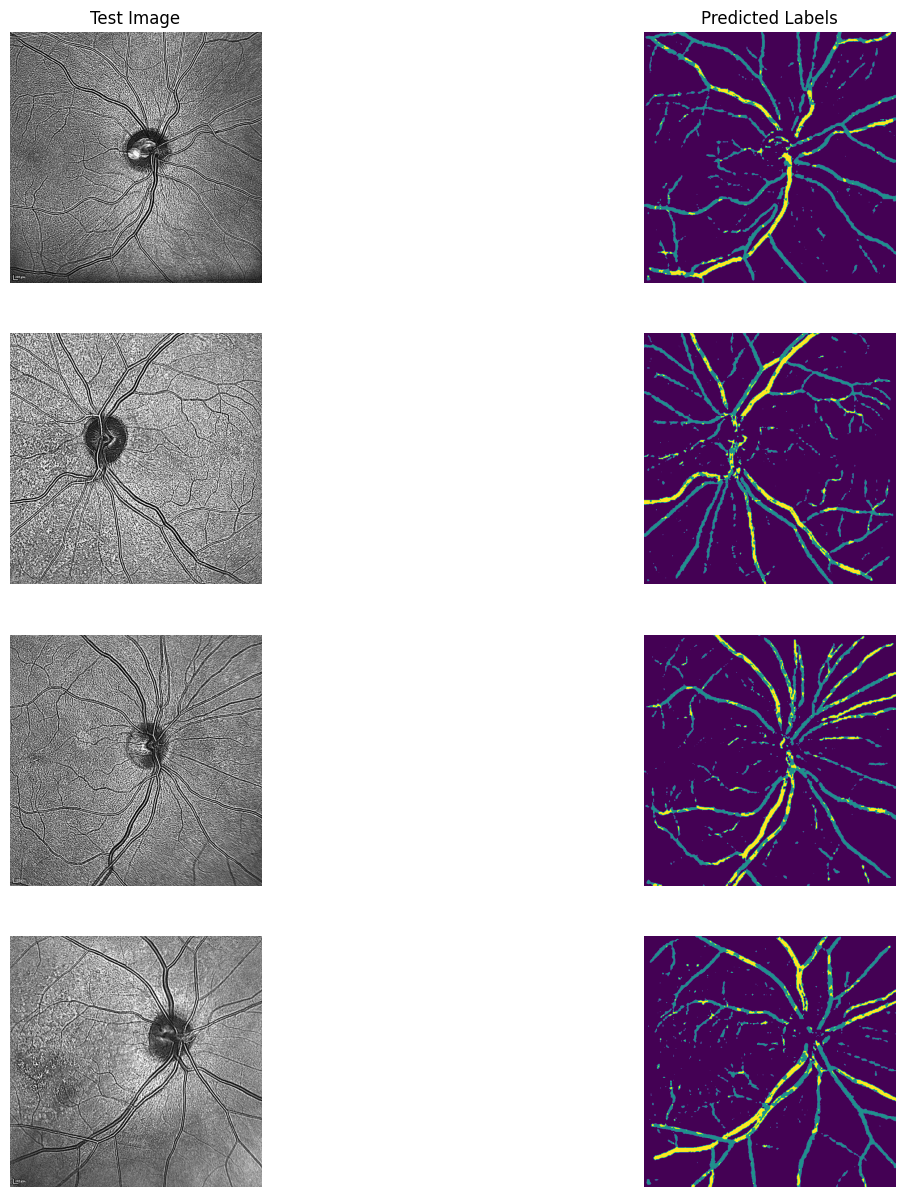

In [20]:
# Display some test images and predictions

plt.figure()

f, axarr = plt.subplots(4,2,figsize=(15, 15))
axarr[0,0].title.set_text('Test Image')
axarr[0,1].title.set_text('Predicted Labels')

for i in range(4):
  pixel_vals = cv2.imread(os.path.join(root_dir,'test', test_sorted_file_names[i+4]))
  pixel_vals = cv2.cvtColor(pixel_vals, cv2.COLOR_BGR2RGB)
  norm = cv2.normalize(np.moveaxis(pixel_vals,0,-1), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  axarr[i,0].imshow(pixel_vals)
  axarr[i,0].axis('off')
  axarr[i,1].imshow(test_reconstructed_outputs[i+4])
  axarr[i,1].axis('off')

##### Save results

In [21]:
# Create new directory to save test outputs
timestamp = time.strftime("%Y%m%d-%H%M%S")
new_directory_name = 'Test_eval_Dino_Segformer_{timestamp}'
new_directory_path = os.path.join(root_dir,'test', new_directory_name)
os.makedirs(new_directory_path, exist_ok=True)

# Save test outputs
for output, file_name in zip(test_reconstructed_outputs, test_sorted_file_names):
  file_p = os.path.join(root_dir,'test',new_directory_name, file_name)
  output = output * 128
  cv2.imwrite(file_p, output)